# End to end graph generation demo (Epinions)

## Overview

In this notebook, we have walked through the complete process of generating a synthetic dataset based on a Epinions dataset. The Epinions dataset is trust network dataset. For each user, it contains his profile, his ratings and his trust relations.

Content:

1. [Prepare the original dataset](#1)
1. [Preprare SynGen Configuration](#2)
1. [Dataset Generation](#3)
1. [Tabular data evaluation](#4)
1. [Structure evaluation](#5)

### Imports

In [1]:
# preprocessing
from syngen.preprocessing.datasets import EpinionsPreprocessing

# config
from syngen.configuration import SynGenConfiguration

# generation
from syngen.synthesizer import ConfigurationGraphSynthesizer

# evaluation
from syngen.analyzer.tabular import TabularMetrics
from syngen.analyzer.graph import Graph
from syngen.analyzer.graph.stats import get_dd_simmilarity_score
from syngen.analyzer.graph.analyser import AnalysisModule

# utils
import copy
from syngen.utils.types import MetaData

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


<a id="1"></a>
## Prepare original dataset

SynGen requires the data to be in SynGen dataset format or simply SynGen format, so firstly, we transform the raw Cora dataset into SynGen format. If you don't download Epinions before, you may pass `download=True` as `EpinionsPreprocessing` class supports automatic downloading.

In [2]:
data_path = '/workspace/data/epinions'
preprocessed_path = '/workspace/data/epinions_preprocessed'

In [3]:
preprocessing = EpinionsPreprocessing(source_path=data_path, destination_path=preprocessed_path, download=False)

In [4]:
feature_spec_original = preprocessing.transform(use_cache=True)

In [5]:
feature_spec_original

{'nodes': [{'name': 'user',
   'count': 120491,
   'features': [],
   'features_path': None},
  {'name': 'item', 'count': 755759, 'features': [], 'features_path': None}],
 'edges': [{'name': 'user-item',
   'count': 13668320,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [{'name': 'rating',
     'dtype': 'int64',
     'feature_type': 'categorical'}],
   'features_path': 'user-item.parquet',
   'structure_path': 'user-item_edge_list.parquet'},
  {'name': 'user-user',
   'count': 717667,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [],
   'features_path': None,
   'structure_path': 'user-user_edge_list.parquet'}],
 <MetaData.PATH: 'path'>: '/workspace/data/epinions_preprocessed'}

In [6]:
feature_spec_original[MetaData.EDGES][0][MetaData.NAME]

'user-item'

In [7]:
feature_spec_original[MetaData.EDGES][1][MetaData.NAME]

'user-user'

<a id="2"></a>
## Preprare SynGen Configuration

SynGen generation process is driven by the configuration that is the superset of the SynGen format metadata file. Let us create two configurations: a proper one that will mimic Cora dataset tabular and structural features and a random one.

### Proper Synthetic 

In [8]:
feature_spec_synthetic = feature_spec_original.copy()

feature_spec_synthetic[MetaData.EDGES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "kde",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'configuration',
            MetaData.PATH: preprocessed_path,
            MetaData.NAME: "user-item",
        },
        MetaData.PARAMS: {}
    }
]

feature_spec_synthetic[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'cfg', # the same a 'configuration'
        MetaData.PATH: preprocessed_path,
        MetaData.NAME: "user-item",
    },
    MetaData.PARAMS: {}
}

feature_spec_synthetic[MetaData.EDGES][1][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'cfg',
        MetaData.PATH: preprocessed_path,
        MetaData.NAME: "user-user",
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

# aligns 'rating' edge feature based on the 'user-item' and 'user-user' edges
feature_spec_synthetic[MetaData.ALIGNERS] = [
    {
        MetaData.TYPE: "xgboost",
        MetaData.GRAPHS: ["user-item", "user-user"],
        MetaData.NODES: {},
        MetaData.EDGES: {"user-item": ['rating']},
        MetaData.PARAMS: {},
    }
]

config_proper = SynGenConfiguration(feature_spec_synthetic)

In [9]:
config_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'user-item',
   'count': 13668320,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [{'name': 'rating',
     'dtype': 'int64',
     'feature_type': 'categorical'}],
   'features_path': 'user-item.parquet',
   'structure_path': 'user-item_edge_list.parquet',
   <MetaData.TABULAR_GENERATORS: '[gen]tabular_generators'>: [{<MetaData.TYPE: 'type'>: 'kde',
     <MetaData.FEATURES_LIST: 'features_list'>: ['rating'],
     <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'configuration',
      <MetaData.PATH: 'path'>: '/workspace/data/epinions_preprocessed',
      <MetaData.NAME: 'name'>: 'user-item'},
     <MetaData.PARAMS: 'params'>: {}}],
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'cfg',
     <MetaData.PATH: 'path'>: '/workspace/data/epinions_preprocessed',
     <MetaData.NA

### Random 

In [10]:
feature_spec_random = feature_spec_original.copy() 

feature_spec_random[MetaData.EDGES][0][MetaData.TABULAR_GENERATORS] = [
    {
        MetaData.TYPE: "random",
        MetaData.FEATURES_LIST: -1, # copies all tabular features
        MetaData.DATA_SOURCE: {
            MetaData.TYPE: 'random',
        },
        MetaData.PARAMS: {
        }
    }
]

feature_spec_random[MetaData.EDGES][0][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'rnd', # the save as 'random' 
    },
    MetaData.PARAMS: {}
}

feature_spec_random[MetaData.EDGES][1][MetaData.STRUCTURE_GENERATOR] = {
    MetaData.TYPE: "RMAT",
    MetaData.DATA_SOURCE: {
        MetaData.TYPE: 'rnd',
    },
    MetaData.PARAMS: {
        "has_self_loop": False,
    }
}

config_random = SynGenConfiguration(feature_spec_random)

In [11]:
config_random

{<MetaData.EDGES: 'edges'>: [{'name': 'user-item',
   'count': 13668320,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [{'name': 'rating',
     'dtype': 'int64',
     'feature_type': 'categorical'}],
   'features_path': 'user-item.parquet',
   'structure_path': 'user-item_edge_list.parquet',
   <MetaData.TABULAR_GENERATORS: '[gen]tabular_generators'>: [{<MetaData.TYPE: 'type'>: 'random',
     <MetaData.FEATURES_LIST: 'features_list'>: ['rating'],
     <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'random'},
     <MetaData.PARAMS: 'params'>: {}}],
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'rnd'},
    <MetaData.PARAMS: 'params'>: {}}},
  {'name': 'user-user',
   'count': 717667,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [],
   'features_path': None,
 

<a id="3"></a>
## Dataset Generation

In [12]:
save_path_proper = '/workspace/data/epinions_generated'
save_path_random = '/workspace/data/epinions_random'

### Create Synthesizers

In [13]:
synthesizer_proper = ConfigurationGraphSynthesizer(configuration=config_proper, save_path=save_path_proper, gpu=True)
synthesizer_random = ConfigurationGraphSynthesizer(configuration=config_random, save_path=save_path_random, gpu=True)

### Fit Synthesizers

In [14]:
synthesizer_proper.fit()

In [15]:
synthesizer_random.fit()

### Generation

In [16]:
feature_spec_generated_proper = synthesizer_proper.generate()

In [17]:
feature_spec_generated_proper

{<MetaData.EDGES: 'edges'>: [{'name': 'user-item',
   'count': 13668320,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [{'name': 'rating',
     'dtype': 'int64',
     'feature_type': 'categorical'}],
   'features_path': 'user-item.parquet',
   'structure_path': 'user-item_edge_list.parquet',
   <MetaData.TABULAR_GENERATORS: '[gen]tabular_generators'>: [{<MetaData.TYPE: 'type'>: 'kde',
     <MetaData.FEATURES_LIST: 'features_list'>: ['rating'],
     <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'configuration',
      <MetaData.PATH: 'path'>: '/workspace/data/epinions_preprocessed',
      <MetaData.NAME: 'name'>: 'user-item'},
     <MetaData.PARAMS: 'params'>: {'gpu': True, 'verbose': False}}],
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'cfg',
     <MetaData.PATH: 'path'>: '/workspace/data/epinions_pre

In [18]:
feature_spec_generated_random = synthesizer_random.generate()

In [19]:
feature_spec_generated_random

{<MetaData.EDGES: 'edges'>: [{'name': 'user-item',
   'count': 13668320,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'directed': False,
   'features': [{'name': 'rating',
     'dtype': 'int64',
     'feature_type': 'categorical'}],
   'features_path': 'user-item.parquet',
   'structure_path': 'user-item_edge_list.parquet',
   <MetaData.TABULAR_GENERATORS: '[gen]tabular_generators'>: [{<MetaData.TYPE: 'type'>: 'random',
     <MetaData.FEATURES_LIST: 'features_list'>: ['rating'],
     <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'random'},
     <MetaData.PARAMS: 'params'>: {'gpu': True, 'verbose': False}}],
   <MetaData.STRUCTURE_GENERATOR: '[gen]structure_generator'>: {<MetaData.TYPE: 'type'>: 'RMAT',
    <MetaData.DATA_SOURCE: 'data_source'>: {<MetaData.TYPE: 'type'>: 'rnd'},
    <MetaData.PARAMS: 'params'>: {'gpu': True, 'verbose': False}}},
  {'name': 'user-user',
   'count': 717667,
   'src_node_type': 'user',
   'dst_node_type': 'item',
   'direct

<a id="4"></a>
## Tabular Data Evaluation

In [20]:
original_tabular_data, categorical_features = feature_spec_original.get_tabular_data(MetaData.EDGES, 'user-item', return_cat_feats=True)

In [21]:
proper_tabular_data = feature_spec_generated_proper.get_tabular_data(MetaData.EDGES, 'user-item')

In [22]:
random_tabular_data = feature_spec_generated_random.get_tabular_data(MetaData.EDGES, 'user-item')

In [23]:
tab_eval = TabularMetrics(original_tabular_data, 
                          proper_tabular_data, 
                          categorical_columns=categorical_features)

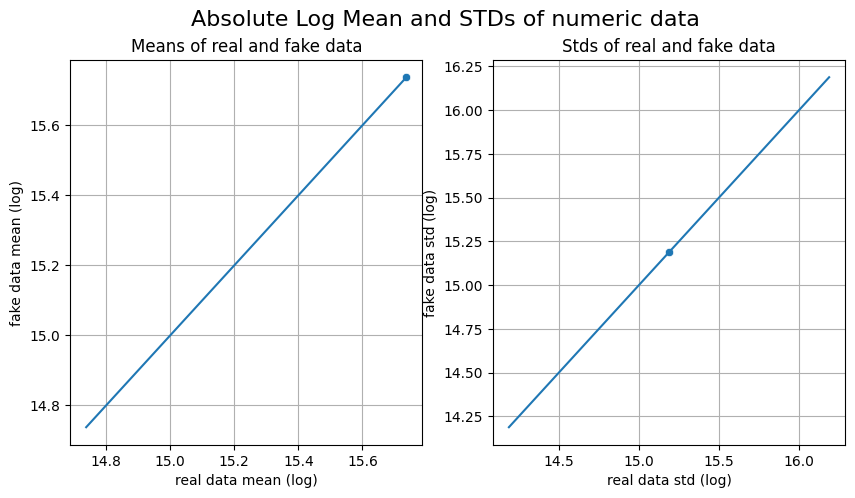

In [24]:
tab_eval.plot_mean_std()

In [25]:
tab_eval = TabularMetrics(original_tabular_data, 
                          random_tabular_data, 
                          categorical_columns=categorical_features)

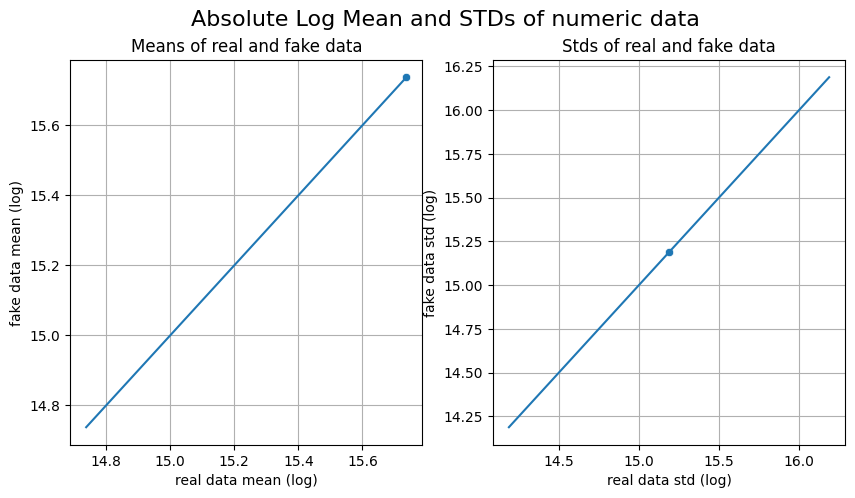

In [26]:
tab_eval.plot_mean_std()

<a id="5"></a>
## Structute Evaluation

In [27]:
original_graph_structure = feature_spec_original.get_structural_data('user-item')
proper_graph_structure = feature_spec_generated_proper.get_structural_data('user-item')
random_graph_structure = feature_spec_generated_random.get_structural_data('user-item')

In [28]:
orig_proper = get_dd_simmilarity_score(original_graph_structure, proper_graph_structure, cdf_points=1000)
orig_random = get_dd_simmilarity_score(original_graph_structure, random_graph_structure, cdf_points=1000)

print("DEGREE SIMILLARITY SCORE")
print("ORIG vs PROPER:", orig_proper)
print("ORIG vs RANDOM:", orig_random)

DEGREE SIMILLARITY SCORE
ORIG vs PROPER: 0.9485071808645863
ORIG vs RANDOM: 0.9600055099479101


In [29]:
original_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_original, 'user-item', graph_name='original')
proper_snap_graph = Graph.instantiate_from_feature_spec(feature_spec_generated_proper, 'user-item', graph_name='properly_generated')
random_graph_structure = Graph.instantiate_from_feature_spec(feature_spec_generated_random, 'user-item', graph_name='randomly_generated')
all_graphs = [original_snap_graph, proper_snap_graph, random_graph_structure]

In [30]:
graph_analyser = AnalysisModule()

In [31]:
df = graph_analyser.compare_graph_stats(*all_graphs)
df

,Category,Statistic,original,properly_generated,randomly_generated
0,Global stats,Nodes,876250,1169052,1169067
1,Global stats,Edges,13667990,13667161,13668210
2,Global stats,Density,0.0,0.0,0.0
3,Global stats,Average degree,15.6,11.69,11.69
4,Global stats,Zero deg nodes,120490,241368,123235
5,Global stats,Zero in deg nodes,120490,241368,123235
6,Global stats,Zero out deg nodes,120490,241368,123235
7,Global stats,Self loops,39,55,8
8,Global stats,Bidirectional edges,13667951,13667106,13668202
9,Global stats,Unique undirected edges,13667951,13667106,13668202


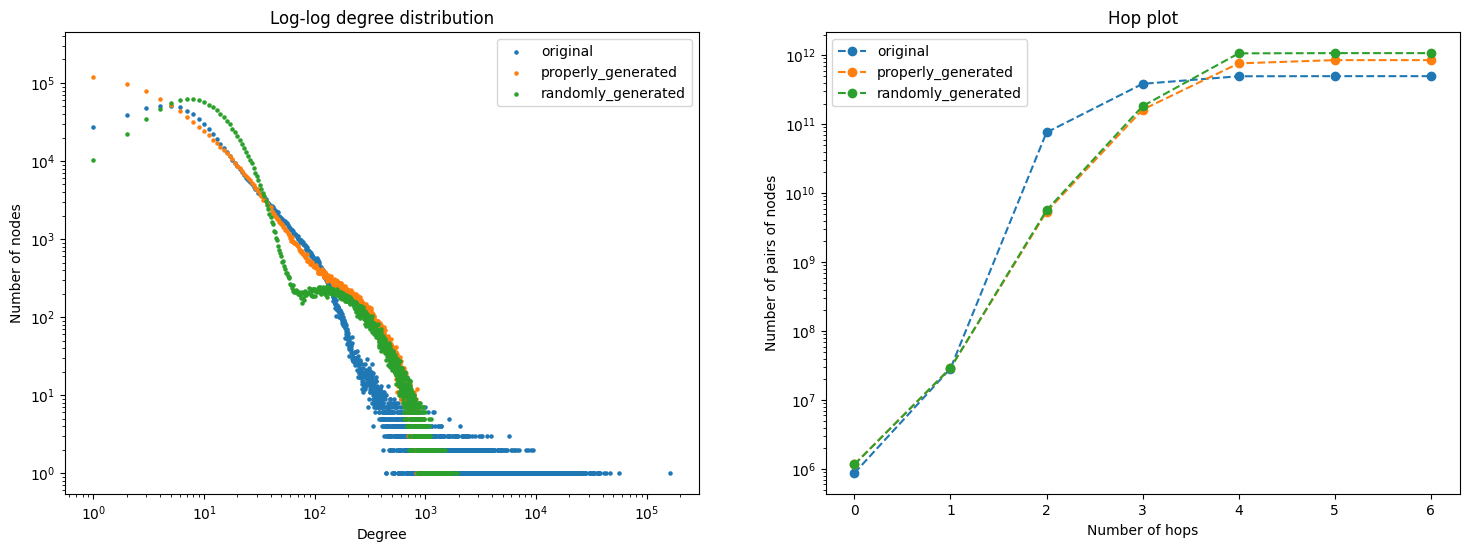

In [32]:
from matplotlib.pyplot import set_loglevel
set_loglevel('warning')
_ = graph_analyser.compare_graph_plots(*all_graphs)